<a href="https://www.kaggle.com/code/leila413y/digit-recognizer-logistic-regression-cnn?scriptVersionId=237776994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Digit Recognizer

The goal of this project is to correctly identify digits from a dataset of tens of thousands of handwritten images. It is evaluated on the categorization accuracy of the predictions.

The data contains gray-scale images of hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

I implemented a logistic regression model as the baseline and used a CNN model for prediction.

# 1 - Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
def load_data():
    train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
    test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
    return train_df, test_df

train_df, test_df = load_data()

# 2 - Exploratory Data Analysis

In [3]:
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
# min, max values of train_df
print(f"min value: {train_df.min().min()}")
print(f"max value: {train_df.max().max()}")

min value: 0
max value: 255


In [7]:
# Check for any missing value
print(f"missing value in train_df: {train_df.isna().sum().sum()}")
print(f"missing value in test_df: {test_df.isna().sum().sum()}")

missing value in train_df: 0
missing value in test_df: 0


In [8]:
# Target distribution in percentage
train_df['label'].value_counts() / train_df.shape[0] * 100

label
1    11.152381
7    10.478571
3    10.359524
9     9.971429
2     9.945238
6     9.850000
0     9.838095
4     9.695238
8     9.673810
5     9.035714
Name: count, dtype: float64

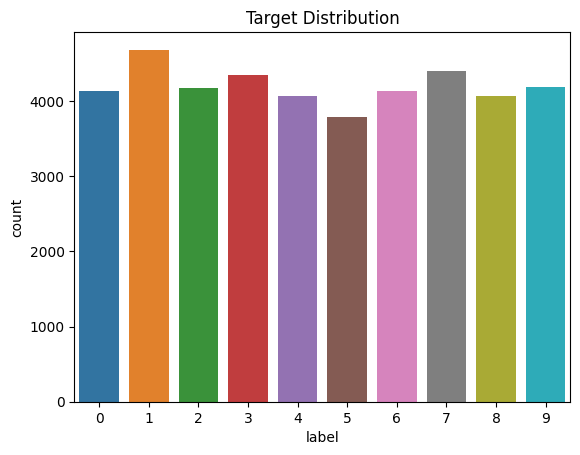

In [9]:
# Target distribution
sns.countplot(data=train_df, x='label')
plt.title('Target Distribution')
plt.show()

# 3 - Preprocessing

In [10]:
def preprocess_df():
    train_df, test_df = load_data()
    
    # Scaling pixel columns
    pixel_cols = list(test_df.columns)
    train_df[pixel_cols] = train_df[pixel_cols] / 255.0
    test_df[pixel_cols] = test_df[pixel_cols] / 255.0
    return train_df, test_df

# 4 - Modeling

## 4.1 Logistic Regression (Baseline)

In [11]:
train_df, test_df = preprocess_df()

X = train_df.copy()
y = X.pop('label')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9198095238095239


## 4.2 CNN

In [12]:
train_df, test_df = preprocess_df()

X = train_df.copy()
y = X.pop('label')

# Reshape to 3D matrices (height = 28px, width = 28px, channel = 1)
X = X.values.reshape(-1, 28, 28, 1)

# One-hot encoding
y = to_categorical(y, num_classes=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
# Define the model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')])
                   
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

# Compile the model
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Set the learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

epochs = 30
batch_size = 64

In [15]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

datagen.fit(X_train)

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                   epochs=epochs,
                   validation_data=(X_test, y_test),
                   verbose=2,
                   steps_per_epoch=X_train.shape[0] // batch_size,
                   callbacks=[learning_rate_reduction])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 - 22s - 37ms/step - accuracy: 0.8810 - loss: 0.3706 - val_accuracy: 0.9790 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 - 0s - 380us/step - accuracy: 0.9844 - loss: 0.0643 - val_accuracy: 0.9812 - val_loss: 0.0610 - learning_rate: 0.0010
Epoch 3/30
590/590 - 12s - 20ms/step - accuracy: 0.9653 - loss: 0.1148 - val_accuracy: 0.9838 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 4/30
590/590 - 0s - 411us/step - accuracy: 0.9688 - loss: 0.0675 - val_accuracy: 0.9843 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 5/30
590/590 - 12s - 20ms/step - accuracy: 0.9749 - loss: 0.0835 - val_accuracy: 0.9898 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 6/30
590/590 - 0s - 413us/step - accuracy: 0.9844 - loss: 0.0568 - val_accuracy: 0.9910 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 7/30
590/590 - 12s - 20ms/step - accuracy: 0.9790 - loss: 0.0683 - val_accuracy: 0.9902 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 8/30
590/590 - 0s - 408us/step - accuracy: 0.9219 - loss: 0.2634 - val_accuracy: 0.9893 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 9/30
590/590 - 12s - 20ms/step - accuracy: 0.9

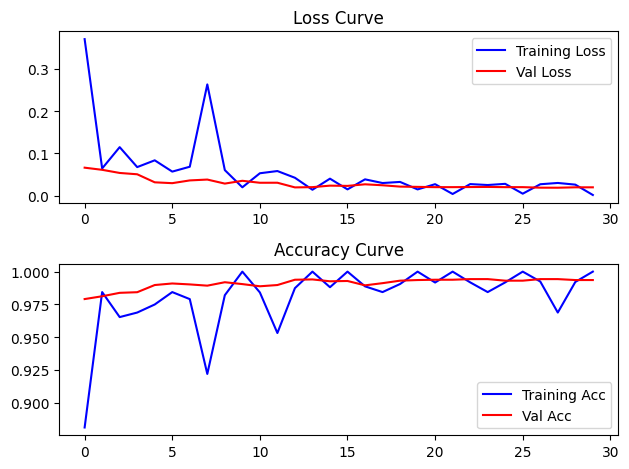

In [16]:
# Plot learning curves
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Val Loss')
ax[0].set_title("Loss Curve")
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label='Training Acc')
ax[1].plot(history.history['val_accuracy'], color='r', label='Val Acc')
ax[1].set_title("Accuracy Curve")
legend = ax[1].legend(loc='best')
plt.tight_layout()

In [17]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_pred, y_true)
print(f"Accuracy: {accuracy}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9935714285714285


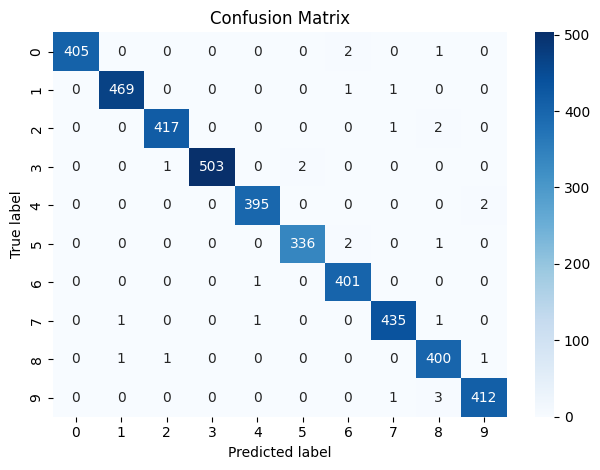

In [18]:
# Draw a confusion matrix
confusion = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [19]:
# Check the missclassified digits
errors_idx = np.where(y_pred != y_true)
errors_idx

(array([  65,   77,  139,  316,  881, 1220, 1314, 1418, 1631, 1889, 1943,
        1991, 2289, 2311, 2393, 2445, 2604, 2638, 2915, 3040, 3073, 3101,
        3536, 4003, 4007, 4106, 4187]),)

True label: 5
Predicted label: 8


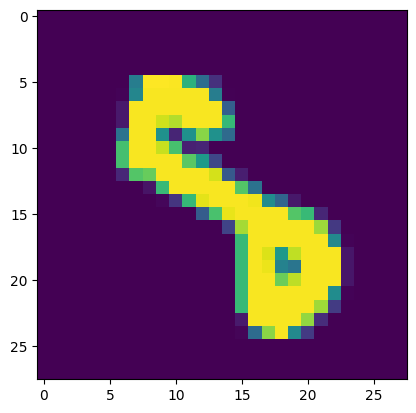

In [20]:
# Check one of the misclassfied image
print(f"True label: {y_true[65]}")
print(f"Predicted label: {y_pred[65]}")
plt.imshow(X_test[65])
plt.show()

In [21]:
test_df = test_df.values.reshape(-1, 28, 28, 1)
final_pred = model.predict(test_df)
final_pred = np.argmax(final_pred, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [22]:
sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sample_submission['Label'] = final_pred

It achieved an accuracy of 0.99453.

*(updated on 2025/03/27)*